# Parallelization with PyTorch and Dask on GPU

In this demo, we will perform a large volume image classification task with a pre-built model.

**Dataset:** [Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html)  
**Model:** [Resnet50](https://arxiv.org/abs/1512.03385)

## Set Up Dask GPU Cluster

Identifies correct worker instance type to ensure GPU capability.

In [1]:
from dask_saturn import SaturnCluster
from dask.distributed import Client
from torchvision import datasets, transforms, models
import re

In [2]:
cluster = SaturnCluster(
    n_workers = 4, 
    scheduler_size = 'medium', 
    worker_size = 'g4dn4xlarge',
    nthreads = 16
)

client = Client(cluster)
client.wait_for_workers(3)
%run -i setup1.py
client.restart()

[2020-12-28 21:00:23] INFO - dask-saturn | Cluster is ready
[2020-12-28 21:00:23] INFO - dask-saturn | Registering default plugins
[2020-12-28 21:00:23] INFO - dask-saturn | {'tcp://10.0.12.247:41225': {'status': 'repeat'}, 'tcp://10.0.15.115:45245': {'status': 'repeat'}, 'tcp://10.0.27.204:45575': {'status': 'repeat'}, 'tcp://10.0.8.13:34583': {'status': 'repeat'}}


Client Scheduler: tcp://d-steph-gpu-batch-inference-55feb18456de488295b5ddbe998c1abc.main-namespace:8786 Dashboard: https://d-steph-gpu-batch-inference-55feb18456de488295b5ddbe998c1abc.internal.saturnenterprise.io,Cluster Workers: 4 Cores: 64 Memory: 254.00 GB


## Assigning Objects to GPU Resources

If you are going to run any processes on GPU resources in a cluster, you need all your objects to be explicitly told this. Otherwise, it won't seek out GPU resources. However, if you use a functional setup (as we are going to do later) you'll need to do this INSIDE your function. Our architecture below will have all that written in. [The PyTorch docs can tell us more.](https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.device)

For the moment, we just need to check that our workers have GPU capability, and assign `device` appropriately.

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing Images

Our goal here is to create a nicely streamlined workflow, including loading, transforming, batching, and labeling images, which we can then run in parallel.

In [4]:
import dask

@dask.delayed
def preprocess(path, fs=__builtins__):
    '''Ingest images directly from S3, apply transformations,
    and extract the ground truth and image identifier. Accepts
    a filepath. '''
    
    transform = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(250), 
        transforms.ToTensor(),
    ])

    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        nvis = transform(img)

    truth = re.search('dogs/Images/n[0-9]+-([^/]+)/n[0-9]+_[0-9]+.jpg', path).group(1)
    name = re.search('dogs/Images/n[0-9]+-[a-zA-Z-_]+/(n[0-9]+_[0-9]+).jpg', path).group(1)
    
    return [name, nvis, truth]

In [5]:
import toolz

s3fpath = 's3://saturn-public-data/dogs/Images/*/*.jpg'
batch_breaks = [list(batch) for batch in toolz.partition_all(80, s3.glob(s3fpath))]

In [6]:
image_batches = [[preprocess(x, fs=s3) for x in y] for y in batch_breaks]
image_batches = [reformat(result) for result in image_batches] 
## reformat is a function defined in the setup1.py file included in repo


Now we have our tensors stacked so that batches can be passed to the model. 

## Check Images

In [21]:
test_set = image_batches[15][0][:5].compute()
test_set

['n02086910_3320',
 'n02086910_3338',
 'n02086910_334',
 'n02086910_336',
 'n02086910_3455']

In [8]:
image_batches[15][2][:5].compute()

['papillon', 'papillon', 'papillon', 'papillon', 'papillon']

In [88]:
import matplotlib.pyplot as plt
cpudevice = torch.device("cpu")
tensorset = image_batches[15].compute()
to_pil = transforms.ToPILImage()

imglist = [to_pil(tensorset[1][0].to(cpudevice)), 
           to_pil(tensorset[1][1].to(cpudevice)),
           to_pil(tensorset[1][2].to(cpudevice)),
           to_pil(tensorset[1][3].to(cpudevice)),
           to_pil(tensorset[1][4].to(cpudevice))]

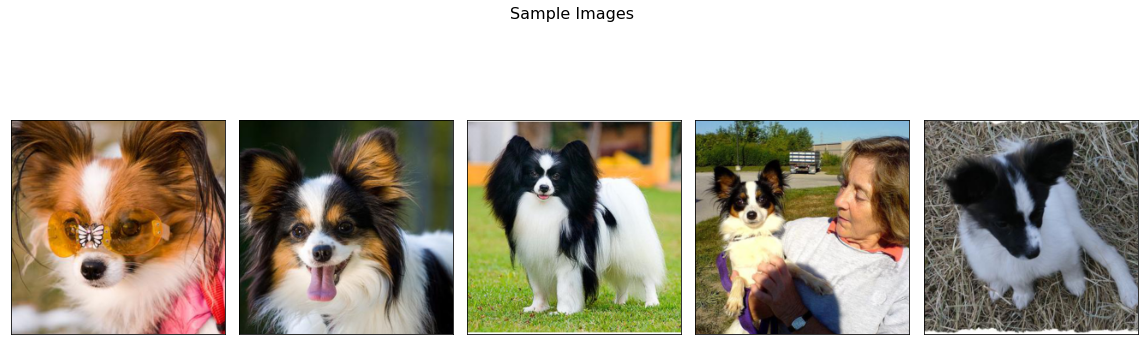

In [89]:
f, ax = plt.subplots(1, 5, figsize=(16,6))

for i in range(0,5):
    img1 = imglist[i]
    ax[i].imshow(img1).axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

title = 'Sample Images'
f.suptitle(title, fontsize=16)
plt.tight_layout()
plt.show()

## Result Processing Functions

We'll use some custom functions to review and assess our results' accuracy. This takes our results from the model, and a few other elements, to return nice readable predictions and the probabilities the model assigned. We have to iterate over each image here, because this function doesn't automatically handle batches.

In [10]:
def evaluate_pred_batch(batch, gtruth, classes):
    ''' Accepts batch of images, returns human readable predictions. '''
    
    _, indices = torch.sort(batch, descending=True)
    percentage = torch.nn.functional.softmax(batch, dim=1)[0] * 100
    
    preds = []
    labslist = []
    for i in range(len(batch)):
        pred = [(classes[idx], percentage[idx].item()) for idx in indices[i][:1]]
        preds.append(pred)

        labs = gtruth[i]
        labslist.append(labs)
        
    return(preds, labslist)

def is_match(label, pred):
    ''' Evaluates human readable prediction against ground truth.'''
    if re.search(label.replace('_', ' '), str(pred).replace('_', ' ')):
        match = True
    else:
        match = False
    return(match)


## Put It All Together

Now, we aren’t going to patch together all these computations by hand, instead we have assembled them in one single delayed function that will do the work for us. Importantly, we can then map this across all our batches of images across the cluster.

In [11]:
@dask.delayed
def run_batch_to_s3(iteritem):
    ''' Accepts iterable result of preprocessing, generates inferences and evaluates. '''
  
    names, images, truelabels = iteritem
    
    with s3.open('s3://saturn-public-data/dogs/imagenet1000_clsidx_to_labels.txt') as f:
        classes = [line.strip() for line in f.readlines()]

    # Retrieve, set up model
    resnet = models.resnet50(pretrained=True)
    resnet = resnet.to(device)

    with torch.no_grad():
        resnet.eval()
        pred_batch = resnet(images)
        
        #Evaluate batch
        preds, labslist = evaluate_pred_batch(pred_batch, truelabels, classes)

        #Organize prediction results
        outcomes = []
        for j in range(0, len(images)):
            match = is_match(labslist[j], preds[j])            
            outcome = {'name': names[j], 'ground_truth': labslist[j], 
                       'prediction': preds[j], 'evaluation': match}
            outcomes.append(outcome)
    
        return(outcomes)
    #return(names)

## Run the Job
Notice that we're going to use client methods below to ensure that our tasks are distributed across the cluster, run, and then retrieved.

In [12]:
client.restart()

Client Scheduler: tcp://d-steph-gpu-batch-inference-55feb18456de488295b5ddbe998c1abc.main-namespace:8786 Dashboard: https://d-steph-gpu-batch-inference-55feb18456de488295b5ddbe998c1abc.internal.saturnenterprise.io,Cluster Workers: 4 Cores: 64 Memory: 254.00 GB


In [13]:
display(HTML(gpu_links))

In [14]:
%%time
import logging
futures = client.map(run_batch_to_s3, image_batches) 
futures_gathered = client.gather(futures)
futures_computed = client.compute(futures_gathered, sync=False)


results = []
errors = []
## Error handling allows us to capture when an input image is broken
for fut in futures_computed:
    try:
        result = fut.result()
    except Exception as e:
        errors.append(e)
        logging.error(e)
    else:
        results.extend(result)

CPU times: user 14.5 s, sys: 208 ms, total: 14.7 s
Wall time: 3min 42s


## Review Results

Look at the graph for one batch, and spot check output.

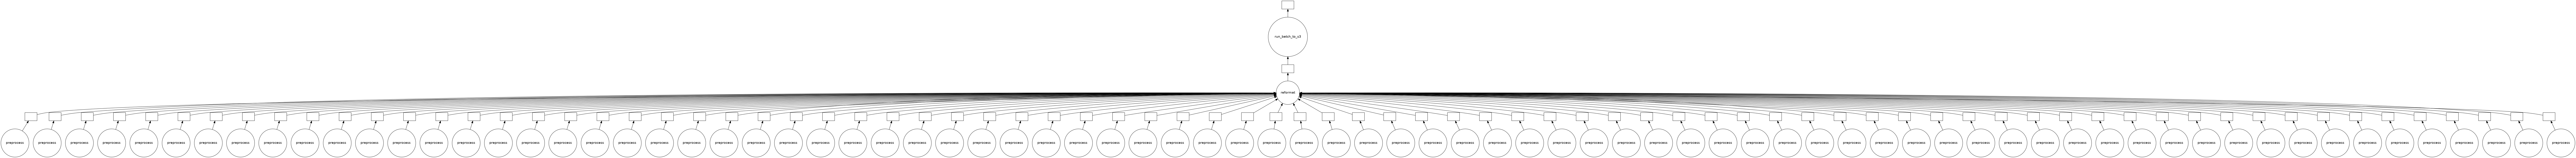

In [15]:
test_sample = run_batch_to_s3(image_batches[0])
test_sample.visualize()

## Size and Format

In [18]:
len(results)

20580

In [19]:
results[0]

{'name': 'n02085620_10074',
 'ground_truth': 'Chihuahua',
 'prediction': [(b"151: 'Chihuahua',", 93.02685546875)],
 'evaluation': True}

### Check Original Sample

In [22]:
papillons = [d for d in results if d['name'] in test_set]
papillons

[{'name': 'n02086910_3320',
  'ground_truth': 'papillon',
  'prediction': [(b"157: 'papillon',", 75.74750518798828)],
  'evaluation': True},
 {'name': 'n02086910_3338',
  'ground_truth': 'papillon',
  'prediction': [(b"157: 'papillon',", 75.74750518798828)],
  'evaluation': True},
 {'name': 'n02086910_334',
  'ground_truth': 'papillon',
  'prediction': [(b"157: 'papillon',", 75.74750518798828)],
  'evaluation': True},
 {'name': 'n02086910_336',
  'ground_truth': 'papillon',
  'prediction': [(b"157: 'papillon',", 75.74750518798828)],
  'evaluation': True},
 {'name': 'n02086910_3455',
  'ground_truth': 'papillon',
  'prediction': [(b"157: 'papillon',", 75.74750518798828)],
  'evaluation': True}]

In [23]:
test_set

['n02086910_3320',
 'n02086910_3338',
 'n02086910_334',
 'n02086910_336',
 'n02086910_3455']

## Lessons Learned

* You can apply `@dask.delayed` to your custom code to allow parallelization with nearly zero refactoring
* Objects that are needed for a parallel task on GPU need to be assigned to a GPU resource
* Passing tasks to the workers uses mapping across the cluster for peak efficiency

And, of course, having multiple workers makes the job a lot faster!
